# Removal of segmented debris from 2D cell cultures

This script is meant to analyse 2D confocal images from Schumacher 2023 figures 4G and H

Import packages, load segmentation model and define input and output paths

In [1]:
import tilesegment.tools.tools as tools
import tilesegment.tools.tiling as tiling
import matplotlib.pyplot as plt

from embdevtools import get_file_embcode, read_img_with_resolution, CellTracking, load_CellTracking, save_4Dstack
from embdevtools.celltrack.core.tools.tools import get_outlines_masks_labels
import numpy as np


### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

from csbdeep.utils import normalize

### PATH TO YOU DATA FOLDER AND TO YOUR SAVING FOLDER ###
path_data='/home/pablo/Desktop/PhD/projects/Data/belas/2D/Sina/activin/crops/movies/'
path_save='/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/reproduce_FACS_results/removed/mean/'


2023-11-19 21:04:44.830196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 21:04:45.783041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-11-19 21:04:46.656544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Define an activin quantity and load images. Activin concentration must be on the format like this `100ng` or `6.25ng` in order to be correctly read.

In [2]:
concentration = "50ng"
### GET FULL FILE NAME AND FILE CODE ###
file, embcode, files = get_file_embcode(path_data, "_"+concentration, allow_file_fragment=True, returnfiles=True)


### LOAD HYPERSTACKS ###
IMGS, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=0)
try: 
    xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
    print("xyres dif =", xyresdif)
    xyres = np.mean(xyres)
except: 
    pass

IMG = IMGS[0,0]

Define tiling information: 

* `Ts` = Tile size
* `D` = Image size after squaring the image and making int multiple of Ts
* `O` = Overlap based on cell nuclei. For example 3 times the mean cell nuclei as observed using the remove debrie script
* `Tso` = Tile size with overlap
* `DO` = total image size with overlap
* `n` = number of tiles in a row or column
* `N` = total number of tiles

In [3]:

### TILING ###

# Tile size
Ts = 1024

# Define overlap by running a segmentation test and checking mean cell diameter after removing small objects
# Total image size
sh = IMG.shape
D = tiling.compute_closest_larger_multiple(max(sh), Ts)

# indexed to be used for image reconstruction
ishdiff = D-sh[0]
top_ishdiff = np.int32(np.ceil(ishdiff/2))
bot_ishdiff = np.int32(np.floor(ishdiff/2))
jshdiff = D-sh[1]
lef_jshdiff = np.int32(np.ceil(jshdiff/2))
rig_jshdiff = np.int32(np.floor(jshdiff/2))

# Size with overlap
O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation

Tso = Ts + 2*O
DO = D + 2*O

# Number of tiles
n = int(D/Ts)
N = int(n**2)

Generate padded image

In [4]:
# Create squared and padded image
IMG_padded = np.zeros((DO,DO))
IMG_padded[O+top_ishdiff:-O-bot_ishdiff, O+lef_jshdiff:-O-rig_jshdiff] = IMG

Pre-allocate variables to be filled during tiling loop. Define a diameter threshold based on the debrie removal results

In [25]:
labels = np.zeros_like(IMG_padded)
maxlab=0

centers = []
masks = []
diameters1 = []
tiles_left = N

diam_th = 0

Loop over tiles rows (`i`) and columns (`j`). Once segmentation is completed, cells falling into the overlaping area must be removed. That what `mins` and `maxs` are used for. Also, `offset` must be computed so that `center`, `outline` and `mask` have indexes corresponding to the whole image, not the tile. 

In [26]:
for i in range(n):
    idsi= slice((i*Ts),((i+1)*Ts+2*O))
    for j in range(n):
        idsj= slice((j*Ts),((j+1)*Ts+2*O))
        img = IMG_padded[idsi, idsj]
        
        labs, _ = model.predict_instances(normalize(img))
        outlines, _masks, _labs = get_outlines_masks_labels(labs) 
        for l, lab in enumerate(_labs):
            outline = outlines[l]
            mask = _masks[l]
            diam = tools.rotating_calipers(outline)
            center = np.mean(mask, axis=0)
            # check if label center falls out of the limits
            mins = O, O
            maxs = Ts+O, Ts+O
            
            if (((center < mins).any() or (center > maxs).any()) or (diam < diam_th)):
                labs[mask[:,0], mask[:,1]] = 0
            else:
                offset = np.array([i*Ts-O-top_ishdiff, j*Ts-O-lef_jshdiff])
                centers.append(center+offset)
                masks.append(mask+offset)
                diameters1.append(diam)

        labs += maxlab
        background = np.transpose(np.where(labs == maxlab))
        labs[background[:,0], background[:,1]] = 0
        maxlab = labs.max()
        labels[idsi, idsj] += labs
        tiles_left -=1
        print("tiles left =", tiles_left)

### SEGMENTATION COMPLETED   ###

1/1 [==============================] - 1s 587ms/step
tiles left = 48
1/1 [==============================] - 1s 574ms/step
tiles left = 47
1/1 [==============================] - 1s 555ms/step
tiles left = 46
1/1 [==============================] - 1s 594ms/step
tiles left = 45
1/1 [==============================] - 1s 568ms/step
tiles left = 44
1/1 [==============================] - 1s 591ms/step
tiles left = 43
1/1 [==============================] - 1s 602ms/step
tiles left = 42
1/1 [==============================] - 1s 577ms/step
tiles left = 41
1/1 [==============================] - 1s 585ms/step
tiles left = 40
1/1 [==============================] - 1s 600ms/step
tiles left = 39
1/1 [==============================] - 1s 607ms/step
tiles left = 38
1/1 [==============================] - 1s 586ms/step
tiles left = 37
1/1 [==============================] - 1s 561ms/step
tiles left = 36
1/1 [==============================] - 1s 557ms/step
tiles left = 35
1/1 [=============================

Once the segmentation is completed we can check the size distribution. Based on the histograms we assume a mixed of 2 gaussians. We check cell diameters based on two methods: 

* `D1` : maximum diameter
* `D2` : diameter obtained from cell area assuming circular cell outline. 

Start computing the second measure

In [27]:
areas = [len(mask) for mask in masks]
diameters2 = [2*np.sqrt(area/np.pi) for area in areas]

Import packages required for gaussian mixture estimation

In [28]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema

x = np.arange(0, step=0.005,stop=50)

Compute gaussian mixture for first case `D1`

In [29]:
# Fit a GMM with 2 components to the data
gmm1 = GaussianMixture(n_components=2)
gmm1.fit(np.array(diameters1).reshape(-1, 1))

# Get means and standard deviations of the two components
means1 = gmm1.means_.flatten()
stds1 = np.sqrt(gmm1.covariances_).flatten()

gcs1 = []
d_cells1 =np.max(means1)
d_debris1 = np.min(means1)
for i in range(len(means1)):
    gcs1.append(norm.pdf(x, means1[i], stds1[i])*gmm1.weights_[i])

gc1 = np.sum(gcs1, axis=0)
local_minima = argrelextrema(gc1, np.less)[0]
if len(local_minima) == 0:
    th1 = 0
else:
    id1 = local_minima[0]
    th1 = x[id1]
    

Now print and display the resulting distributions

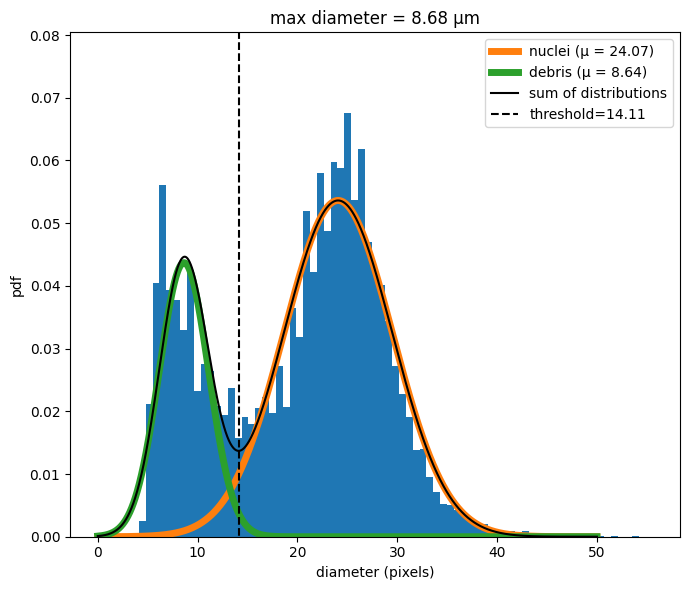

In [30]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(diameters1, bins=75, density=True)
nuc_id = np.argmax(means1)
ax.plot(x, gcs1[nuc_id], label="nuclei (µ = %.2f)" %d_cells1, lw=5)

if len(local_minima)!=0:
    debris_id = np.argmin(means1)
    ax.plot(x, gcs1[debris_id], label="debris (µ = %.2f)" %d_debris1, lw=5)
    ax.plot(x, gc1, c='k', label="sum of distributions")
    ax.plot(x[id1]*np.ones(100), np.linspace(-0.1,np.max(gc1)+0.5*np.max(gc1), 100), ls='--',c='k', label="threshold=%.2f" %x[id1])
    ax.set_ylim(0, np.max(gc1))
    plt.ylim(0, np.max(gc1)+0.5*np.max(gc1))

ax.set_xlabel("diameter (pixels)")
ax.set_ylabel("pdf")
plt.legend()
plt.title("max diameter = %0.2f µm" %(d_cells1*xyres))
plt.tight_layout()
plt.show()

Another option is to use KDE and finde the local minima of the fit.

[53]


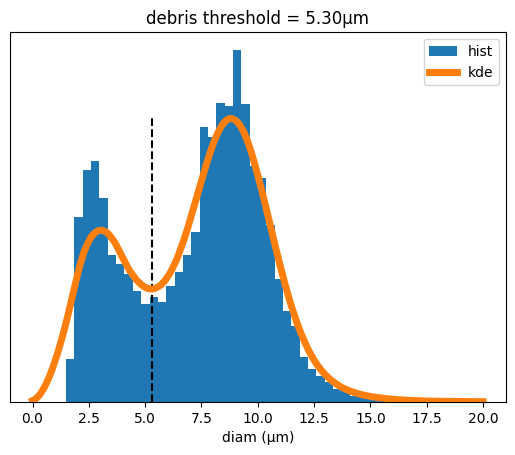

In [36]:
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

data = np.array(diameters1) * xyres
x = np.arange(0, step=0.1, stop=np.max(data))
bw = 2.0
modelo_kde = KernelDensity(kernel='linear', bandwidth=bw)
modelo_kde.fit(X=data.reshape(-1, 1))
densidad_pred = np.exp(modelo_kde.score_samples(x.reshape((-1,1))))
local_minima = argrelextrema(densidad_pred, np.less)[0]
print(local_minima)
x_th = np.ones(len(x))*x[local_minima[0]]
y_th = np.linspace(0, np.max(densidad_pred), num=len(x))
plt.plot(x_th, y_th, c='k', ls='--')
plt.hist(data, bins=50, density=True, label="hist")
plt.plot(x, densidad_pred, lw=5, label="kde")
plt.legend()
plt.xlabel("diam (µm)")
plt.yticks([])
plt.title("debris threshold = {:0.2f}µm".format(x[local_minima[0]]))
plt.savefig("/home/pablo/test.png")
plt.show()

Compute gaussian mixture for first case `D2`

In [42]:
x = np.arange(0, step=0.005,stop=50)

# Fit a GMM with 2 components to the data
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(np.array(diameters2).reshape(-1, 1))

# Get means and standard deviations of the two components
means2 = gmm2.means_.flatten()
stds2 = np.sqrt(gmm2.covariances_).flatten()

gcs2 = []
d_cells2 =np.max(means2)
d_debris1 = np.min(means2)
for i in range(len(means2)):
    gcs2.append(norm.pdf(x, means2[i], stds2[i])*gmm2.weights_[i])

gc2 = np.sum(gcs2, axis=0)
local_minima = argrelextrema(gc2, np.less)[0]
if len(local_minima) == 0:
    th2 = 0
else:
    id2 = local_minima[0]
    th2 = x[id2]

Now print and display the resulting distributions

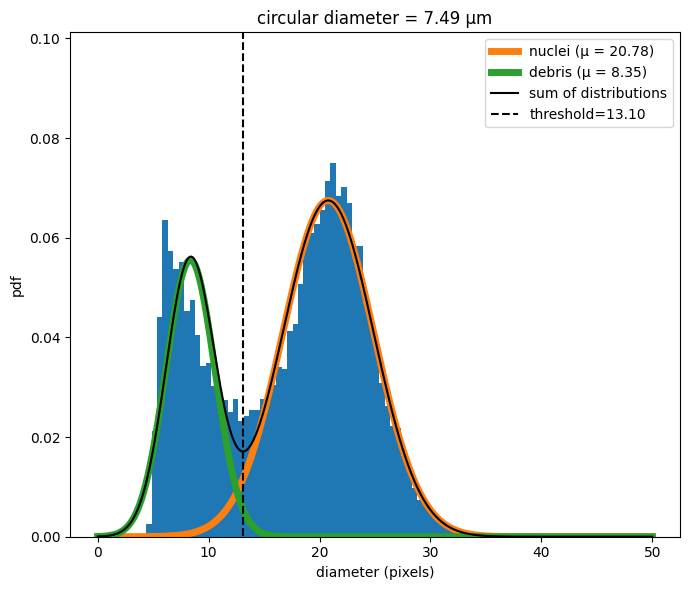

In [43]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(diameters2, bins=75, density=True)
nuc_id = np.argmax(means2)
ax.plot(x, gcs2[nuc_id], label="nuclei (µ = %.2f)" %d_cells2, lw=5)

if len(local_minima)!=0:
    debris_id = np.argmin(means2)
    ax.plot(x, gcs2[debris_id], label="debris (µ = %.2f)" %d_debris1, lw=5)
    ax.plot(x, gc2, c='k', label="sum of distributions")
    ax.plot(x[id2]*np.ones(100), np.linspace(-0.1,np.max(gc2)+0.5*np.max(gc2), 100), ls='--',c='k', label="threshold=%.2f" %x[id2])
    ax.set_ylim(0, np.max(gc2))
    plt.ylim(0, np.max(gc2)+0.5*np.max(gc2))

ax.set_xlabel("diameter (pixels)")
ax.set_ylabel("pdf")
plt.legend()
plt.title("circular diameter = %0.2f µm" %(d_cells2*xyres))
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/removed_cellsize_circulardiam_%s.png" %concentration)
plt.show()

Print statistics for both cases: 

In [44]:
# Number of segmented objects
print("# of segmented objects =", len(centers))

# of which actual cells
ncells = 0
for diam in diameters1:
    if diam > th1:
        ncells+=1
print("# of cells =", ncells)

# of which debris
print("# of removed objects =", len(diameters1) - ncells)

# max diam
print("# max diam =", d_cells1)

# th
print("# th1 diam =", th1)

# circ diam
print("# circ diam =", d_cells2)

# th
print("# th2 diam =", th2)

# of segmented objects = 42268
# of cells = 30054
# of removed objects = 12214
# max diam = 24.07150832020636
# th1 diam = 14.11
# circ diam = 20.78124615594111
# th2 diam = 13.1
